# 1. Configuración inicial y utilidades

## 1.1. Importación de librerías

In [23]:
# Tratamiento de datos
import numpy as np
import pandas as pd

# Conexión SQL Server
import pyodbc

# Manejo de fechas y ambiente
from datetime import datetime
import os

# Gráficos
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.express as px

# Modelado y forecasting
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from skforecast.model_selection import backtesting_forecaster, grid_search_forecaster

## 1.2. Configuración de estilos gráficos y warnings

In [24]:
# Warnings y estilos
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5

# Para notebooks (opcional)
%matplotlib inline

In [25]:
import contextlib
import sys
@contextlib.contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, 'w') as fnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = fnull
        sys.stderr = fnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

## 1.3. Funciones utilitarias (SQL, blobs, fechas, subida/descarga de datos)


In [26]:
# 1. Obtener cadena de conexión
def get_connection_string(
    server: str = 'localhost', 
    database: str = 'FlujoVehicular', 
    username: str = 'sa', 
    password: str = 'StrongPassw0rd!',
    driver: str = '{ODBC Driver 17 for SQL Server}'
):
    return f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password};'

# 2. Cargar datos de una tabla a DataFrame
def get_blob_to_df(table_name: str, connection_str: str):
    try:
        with pyodbc.connect(connection_str, autocommit=True) as conn:
            query = f"SELECT * FROM {table_name};"
            df = pd.read_sql(query, conn)
        return True, df
    except Exception as e:
        return False, str(e)

# 3. Guardar resultados con fecha de ejecución
def guardar_resultados(datos: pd.DataFrame, modelo: str):
    fecha_ejecucion = datetime.now()
    resultados = pd.DataFrame({
        'date_time': datos.index,
        'prediccion': datos['pred'],
        'modelo': modelo,
        'execution_date': fecha_ejecucion
    })
    return resultados

# 4. Guardar pronóstico sin fecha de ejecución
def guardar_pronostico(datos: pd.DataFrame, modelo: str):
    resultados = pd.DataFrame({
        'date_time': datos.index,
        'prediccion': datos['pred'],
        'modelo': modelo
    })
    return resultados

# 5. Subir DataFrame a SQL Server (sin optimización por lotes)
def upload_df_to_blob(df: pd.DataFrame, table_name: str, connection_str: str):
    try:
        df = df.where(pd.notnull(df), None)
        with pyodbc.connect(connection_str, autocommit=True) as conn:
            cursor = conn.cursor()
            columns = ','.join(df.columns)
            placeholders = ','.join(['?'] * len(df.columns))
            cmd_insert = f"INSERT INTO {table_name} ({columns}) VALUES ({placeholders})"
            cursor.fast_executemany = True
            cursor.executemany(cmd_insert, df.values.tolist())
        return True, ""
    except Exception as e:
        return False, str(e)

# 6. Subir DataFrame a SQL Server en lotes (opcional, recomendado si hay muchos datos)
def upload_df_to_blob_with_steroids(df: pd.DataFrame, table_name: str, connection_str: str, batch_size: int = 5000):
    try:
        df = df.where(pd.notnull(df), None)
        with pyodbc.connect(connection_str, autocommit=False) as conn:
            cursor = conn.cursor()
            columns = ','.join(df.columns)
            placeholders = ','.join(['?'] * len(df.columns))
            cmd_insert = f"INSERT INTO {table_name} ({columns}) VALUES ({placeholders})"
            cursor.fast_executemany = True
            for start in range(0, len(df), batch_size):
                end = start + batch_size
                batch = df.iloc[start:end].values.tolist()
                cursor.executemany(cmd_insert, batch)
                conn.commit()
        return True, ""
    except Exception as e:
        return False, str(e)

# 7. Crear tabla SQL
def crear_tabla_sql(connection_str: str, sql_create: str):
    try:
        with pyodbc.connect(connection_str, autocommit=True) as conn:
            cursor = conn.cursor()
            cursor.execute(sql_create)
        print("Tabla creada correctamente.")
    except Exception as e:
        print(f"Error al crear la tabla: {e}")


# 2. Conexión y extracción de datos

## 2.1. Generación de string de conexión a SQL Server


In [27]:
# Conexión a SQL Server
# Si ejecutas el notebook desde fuera de Docker: usa 'localhost'
cnn = get_connection_string(
    server='localhost,1433',            # O 'sqlserver' según tu entorno
    database='FlujoVehicular',
    username='sa',
    password='StrongPassw0rd!'
)

print("Cadena de conexión lista.")

Cadena de conexión lista.


## 2.2. Descarga de tablas principales (Hechos y dimensiones)

In [28]:
# Descarga de la tabla de hechos principal
ok, df_fact = get_blob_to_df(table_name='fact_pasos', connection_str=cnn)
if not ok:
    raise Exception(f"Error al extraer fact_pasos: {df_fact}")

# Descarga de las dimensiones principales
ok, dim_hora = get_blob_to_df(table_name='dim_hora', connection_str=cnn)
if not ok:
    raise Exception(f"Error al extraer dim_hora: {dim_hora}")

ok, dim_estacion = get_blob_to_df(table_name='dim_estacion', connection_str=cnn)
if not ok:
    raise Exception(f"Error al extraer dim_estacion: {dim_estacion}")

ok, dim_sentido = get_blob_to_df(table_name='dim_sentido', connection_str=cnn)
if not ok:
    raise Exception(f"Error al extraer dim_sentido: {dim_sentido}")

ok, dim_tipo_vehiculo = get_blob_to_df(table_name='dim_tipo_vehiculo', connection_str=cnn)
if not ok:
    raise Exception(f"Error al extraer dim_tipo_vehiculo: {dim_tipo_vehiculo}")

ok, dim_forma_pago = get_blob_to_df(table_name='dim_forma_pago', connection_str=cnn)
if not ok:
    raise Exception(f"Error al extraer dim_forma_pago: {dim_forma_pago}")

ok, dim_fecha = get_blob_to_df(table_name='dim_fecha', connection_str=cnn)
if not ok:
    raise Exception(f"Error al extraer dim_fecha: {dim_fecha}")

print("Tablas extraídas correctamente.")

Tablas extraídas correctamente.


## 2.3. Descripción del dataset (periodo, fecha, hora_inicio, estacion, etc.)

In [29]:
# Vista rápida a la tabla de hechos
print("Tabla de hechos:")
display(df_fact.head())

# Diccionario de columnas (describe el contenido de cada una)
descripcion_columnas = {
    'periodo': 'Año del registro (ej. 2017)',
    'fecha': 'Fecha de la medición (YYYY-MM-DD)',
    'hora_id': 'ID de la hora en la dimensión hora',
    'estacion_id': 'ID de la estación en la dimensión estación',
    'sentido_id': 'ID del sentido en la dimensión sentido',
    'tipo_vehiculo_id': 'ID del tipo de vehículo',
    'forma_pago_id': 'ID de la forma de pago',
    'cantidad_pasos': 'Total de vehículos registrados'
}

print("Descripción de las columnas de fact_pasos:")
for col, desc in descripcion_columnas.items():
    print(f"- {col}: {desc}")

# Cantidad de registros y rango de fechas
print(f"\nTotal de registros: {len(df_fact)}")
print(f"Fecha mínima: {df_fact['fecha'].min()} | Fecha máxima: {df_fact['fecha'].max()}")


Tabla de hechos:


,periodo,fecha,hora_id,estacion_id,sentido_id,tipo_vehiculo_id,forma_pago_id,cantidad_pasos
0,2017,2017-01-01,0,1,1,3,7,252
1,2017,2017-01-01,0,1,1,3,2,1
2,2017,2017-01-01,0,1,1,3,12,100
3,2017,2017-01-01,0,1,1,9,12,2
4,2017,2017-01-01,0,1,1,9,12,1


Descripción de las columnas de fact_pasos:
- periodo: Año del registro (ej. 2017)
- fecha: Fecha de la medición (YYYY-MM-DD)
- hora_id: ID de la hora en la dimensión hora
- estacion_id: ID de la estación en la dimensión estación
- sentido_id: ID del sentido en la dimensión sentido
- tipo_vehiculo_id: ID del tipo de vehículo
- forma_pago_id: ID de la forma de pago
- cantidad_pasos: Total de vehículos registrados

Total de registros: 1048575
Fecha mínima: 2017-01-01 | Fecha máxima: 2020-12-31


# 3. Procesamiento y limpieza de datos

## 3.1. Conversión de formatos de fecha y hora

In [30]:
# Aseguramos que la columna fecha sea tipo datetime
df_fact['fecha'] = pd.to_datetime(df_fact['fecha'])

# Si tienes la columna 'hora_id' y quieres la hora en formato TIME, une con dim_hora:
df_fact = df_fact.merge(dim_hora.rename(columns={'hora_id': 'hora_id', 'hora': 'hora_sql'}), how='left', on='hora_id')

# Muestra de la conversión
print(df_fact[['fecha', 'hora_id', 'hora_sql']].head())

       fecha  hora_id  hora_sql
0 2017-01-01        0  00:00:00
1 2017-01-01        0  00:00:00
2 2017-01-01        0  00:00:00
3 2017-01-01        0  00:00:00
4 2017-01-01        0  00:00:00


# 4. Análisis exploratorio y visualización

## 4.1. Estadísticas descriptivas y rangos de fechas

In [31]:
print("Resumen general de cantidad_pasos:")
print(df_fact['cantidad_pasos'].describe())

print("\nCantidad de registros por año:")
print(df_fact.groupby(df_fact['fecha'].dt.year)['cantidad_pasos'].count())

print(f"\nFecha mínima: {df_fact['fecha'].min()}")
print(f"Fecha máxima: {df_fact['fecha'].max()}")

Resumen general de cantidad_pasos:
count    1.048575e+06
mean     1.146087e+02
std      3.448687e+02
min      1.000000e+00
25%      2.000000e+00
50%      6.000000e+00
75%      2.500000e+01
max      5.330000e+03
Name: cantidad_pasos, dtype: float64

Cantidad de registros por año:
fecha
2017    291900
2018    299519
2019    161133
2020    296023
Name: cantidad_pasos, dtype: int64

Fecha mínima: 2017-01-01 00:00:00
Fecha máxima: 2020-12-31 00:00:00


## 4.2. Gráficos de barras por día de semana

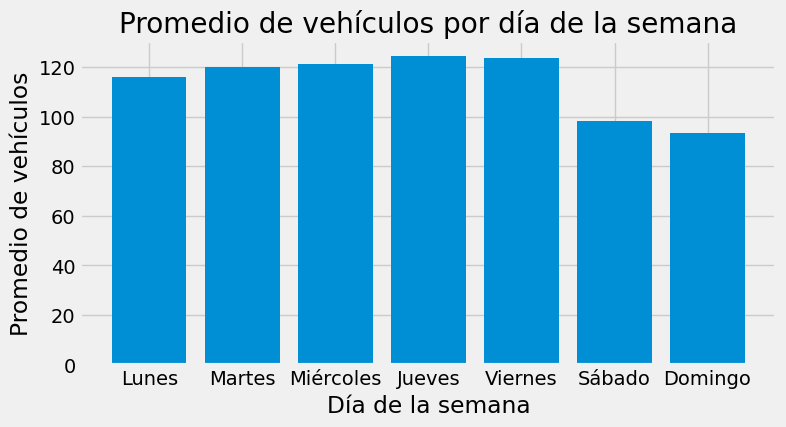

In [32]:
# Añadimos columna con día de la semana (0=Lunes, 6=Domingo)
df_fact['dia_semana'] = df_fact['fecha'].dt.dayofweek

dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
promedio_dia = df_fact.groupby('dia_semana')['cantidad_pasos'].mean()

plt.figure(figsize=(8,4))
plt.bar(dias, promedio_dia)
plt.title('Promedio de vehículos por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Promedio de vehículos')
plt.show()

## 4.3. Serie temporal de tráfico vehicular (simple y con zoom)

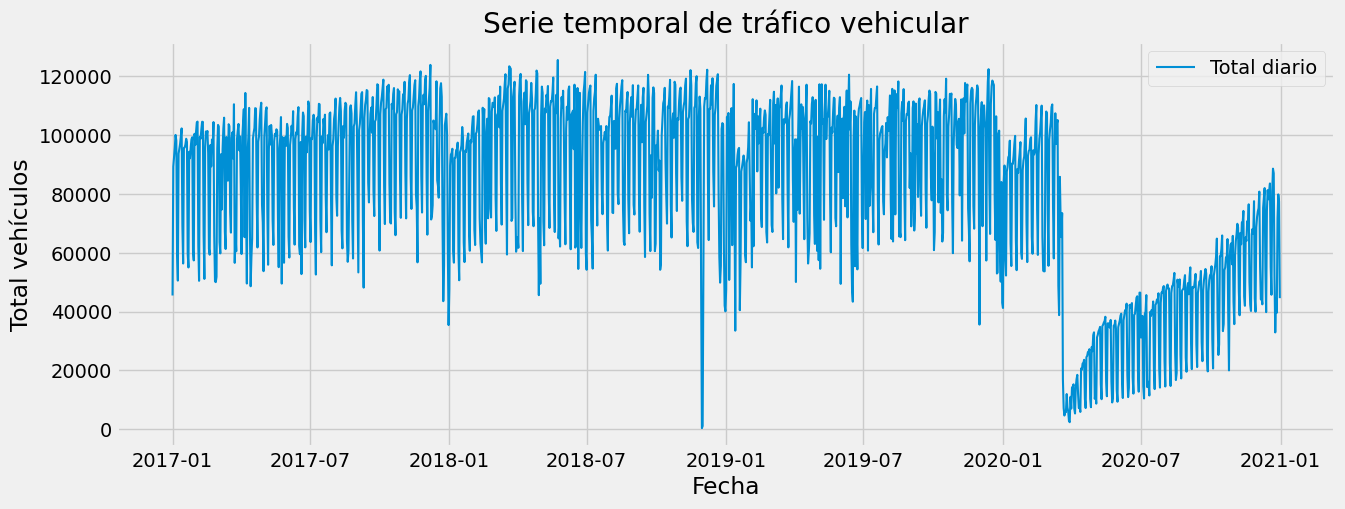

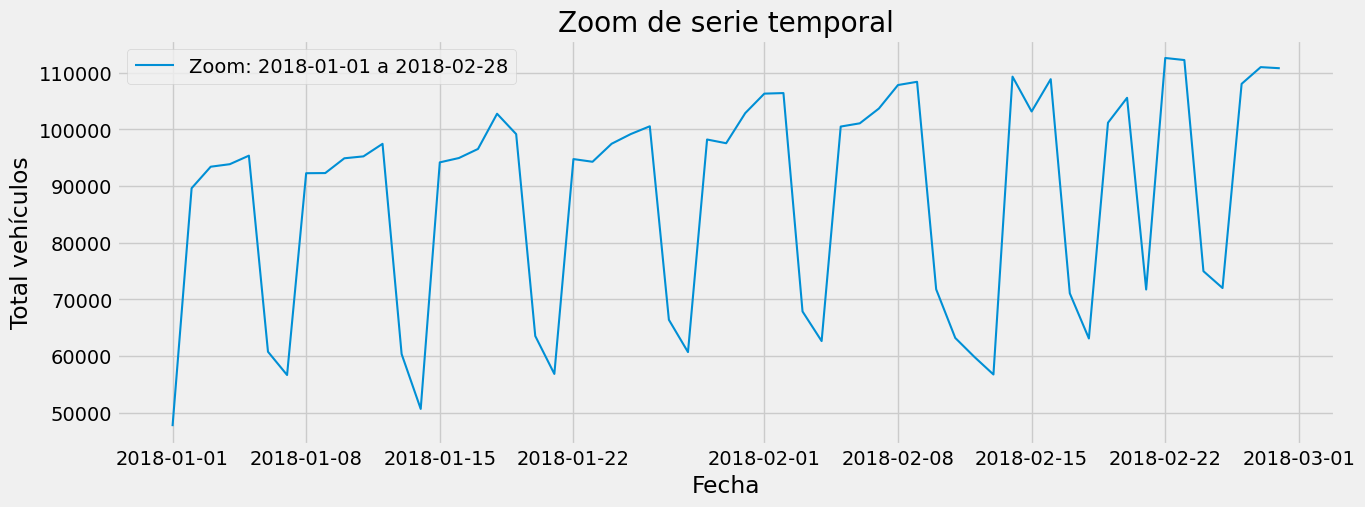

In [33]:
# Agrupamos por fecha para ver tendencia diaria
serie_diaria = df_fact.groupby('fecha')['cantidad_pasos'].sum()

plt.figure(figsize=(14,5))
plt.plot(serie_diaria, label='Total diario')
plt.title('Serie temporal de tráfico vehicular')
plt.xlabel('Fecha')
plt.ylabel('Total vehículos')
plt.legend()
plt.show()

# Zoom a un periodo específico
zoom_inicio = '2018-01-01'
zoom_fin = '2018-02-28'
plt.figure(figsize=(14,5))
plt.plot(serie_diaria.loc[zoom_inicio:zoom_fin], label=f'Zoom: {zoom_inicio} a {zoom_fin}')
plt.title('Zoom de serie temporal')
plt.xlabel('Fecha')
plt.ylabel('Total vehículos')
plt.legend()
plt.show()


## 4.4. Gráficos interactivos con Plotly

In [34]:
import plotly.express as px

fig = px.line(
    x=serie_diaria.index,
    y=serie_diaria.values,
    labels={'x': 'Fecha', 'y': 'Total vehículos'},
    title='Serie temporal interactiva de tráfico vehicular'
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

## 4.5. Estacionalidad diaria y boxplots

<Figure size 1200x600 with 0 Axes>

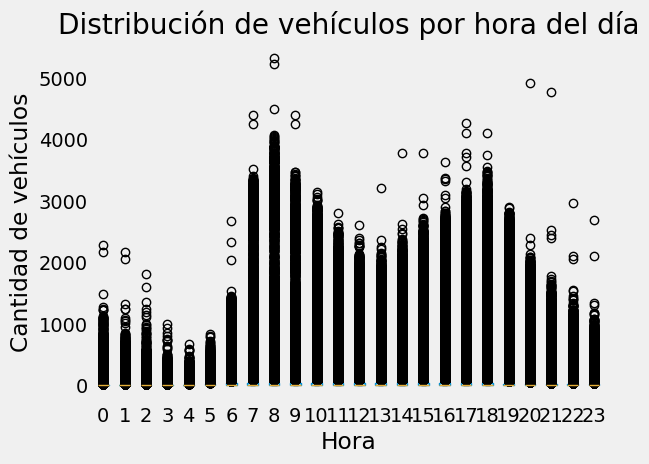

In [35]:
# Boxplot por hora del día (sumando todas las fechas)
df_fact = df_fact.merge(dim_hora[['hora_id', 'hora']], how='left', on='hora_id')
df_fact['hora_num'] = df_fact['hora'].astype(str).str[:2].astype(int)

plt.figure(figsize=(12,6))
df_fact.boxplot(column='cantidad_pasos', by='hora_num', grid=False)
plt.title('Distribución de vehículos por hora del día')
plt.suptitle('')
plt.xlabel('Hora')
plt.ylabel('Cantidad de vehículos')
plt.show()


## 4.6. Análisis de autocorrelación y autocorrelación parcial

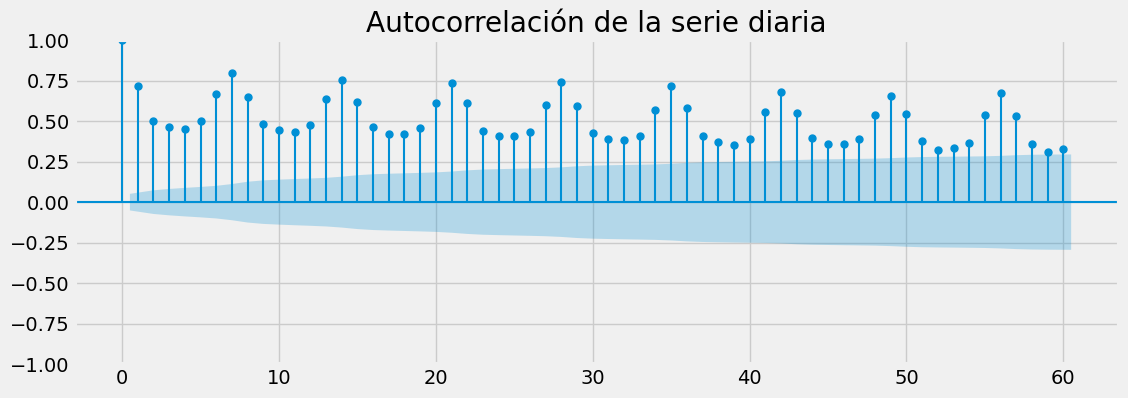

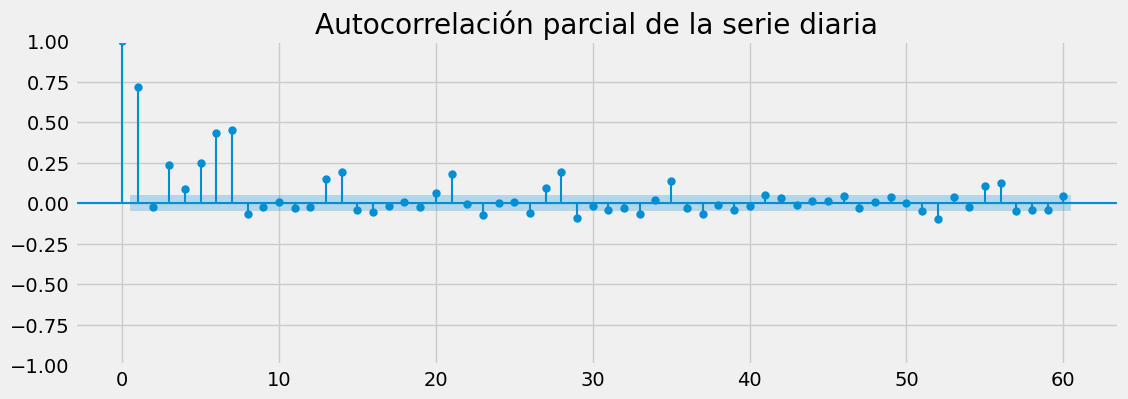

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Usamos la serie diaria agregada (puedes usar frecuencia horaria si lo prefieres)
plt.figure(figsize=(12,4))
plot_acf(serie_diaria, lags=60, ax=plt.gca())
plt.title('Autocorrelación de la serie diaria')
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(serie_diaria, lags=60, ax=plt.gca(), method='ywm')
plt.title('Autocorrelación parcial de la serie diaria')
plt.show()


# 5. Preprocesamiento avanzado

## 5.2. Agrupación por fecha y hora

In [37]:
df_fact['datetime'] = pd.to_datetime(df_fact['fecha'].astype(str) + ' ' + df_fact['hora_sql'].astype(str))

# Suma total por datetime (target)
datos = df_fact.groupby('datetime')['cantidad_pasos'].sum().to_frame('traffic_count')

## 5.3. Relleno de valores nulos (estrategias)

In [38]:
# Chequeo de nulos
print("Valores nulos antes:", datos.isnull().sum())

Valores nulos antes: traffic_count    0
dtype: int64


In [39]:
# Variables temporales
datos['hour'] = datos.index.hour
datos['month'] = datos.index.month
datos['weekday'] = datos.index.weekday
datos['period'] = np.where(datos['hour'] < 12, 'AM', 'PM')  # Ejemplo: AM/PM

In [40]:
datos['period'] = datos['period'].astype('category')
datos['month'] = datos['month'].astype('category')
datos['weekday'] = datos['weekday'].astype('category')

## 5.4. Transformaciones de variables: seno-coseno, one-hot, etc.

In [41]:
# Seno-coseno hora
datos['hour_sin'] = np.sin(datos['hour'] / 23 * 2 * np.pi)
datos['hour_cos'] = np.cos(datos['hour'] / 23 * 2 * np.pi)
datos = datos.drop(columns='hour')

# One hot encoding para las temporales
datos = pd.get_dummies(datos, columns=['period', 'month', 'weekday'])

# Convertir columnas dummies a tipo numérico (para evitar errores con XGBoost)
dummy_columns = [col for col in datos.columns if any(x in col for x in ['period_', 'month_', 'weekday_'])]
for col in dummy_columns:
    datos[col] = datos[col].astype(int)

In [42]:
full_index = pd.date_range(datos.index.min(), datos.index.max(), freq='H')
datos = datos.reindex(full_index)
datos.interpolate(method='time', inplace=True)
datos.fillna(0, inplace=True)
datos.sort_index(inplace=True)

In [43]:
datos

,traffic_count,hour_sin,hour_cos,period_AM,period_PM,month_1,month_2,month_3,month_4,month_5,...,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
2017-01-01 00:00:00,598.0,0.000000e+00,1.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-01-01 01:00:00,2222.0,2.697968e-01,0.962917,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-01-01 02:00:00,2632.0,5.195840e-01,0.854419,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-01-01 03:00:00,1780.0,7.308360e-01,0.682553,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-01-01 04:00:00,794.0,8.878852e-01,0.460065,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,2602.0,-8.878852e-01,0.460065,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2020-12-31 20:00:00,2830.0,-7.308360e-01,0.682553,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2020-12-31 21:00:00,1865.0,-5.195840e-01,0.854419,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2020-12-31 22:00:00,480.0,-2.697968e-01,0.962917,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [44]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2017-01-01 00:00:00 to 2020-12-31 23:00:00
Freq: h
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   traffic_count  35064 non-null  float64
 1   hour_sin       35064 non-null  float64
 2   hour_cos       35064 non-null  float64
 3   period_AM      35064 non-null  float64
 4   period_PM      35064 non-null  float64
 5   month_1        35064 non-null  float64
 6   month_2        35064 non-null  float64
 7   month_3        35064 non-null  float64
 8   month_4        35064 non-null  float64
 9   month_5        35064 non-null  float64
 10  month_6        35064 non-null  float64
 11  month_7        35064 non-null  float64
 12  month_8        35064 non-null  float64
 13  month_9        35064 non-null  float64
 14  month_10       35064 non-null  float64
 15  month_11       35064 non-null  float64
 16  month_12       35064 non-null  float64
 17  weekday

In [45]:
variables_exogenas = [
    col for col in datos.columns
    if col != 'traffic_count'  # todas menos el target
]

# 6. División en conjuntos de datos

## 6.1. Definición de periodos de entrenamiento, validación y test

In [46]:
idx = datos.index

n_total = len(idx)
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Cálculo de los límites (redondeando hacia abajo)
n_train = int(n_total * train_ratio)
n_val = int(n_total * val_ratio)

fin_train = idx[n_train - 1]
fin_validacion = idx[n_train + n_val - 1]
inicio_test = idx[n_train + n_val]

# División temporal de los datos
datos_train = datos.loc[:fin_train].copy()
datos_val   = datos.loc[fin_train:fin_validacion].copy()
datos_test  = datos.loc[fin_validacion:].copy()

print(f"Train: {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Validación: {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Test: {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Train: 2017-01-01 00:00:00 --- 2019-10-20 15:00:00  (n=24544)
Validación: 2019-10-20 15:00:00 --- 2020-08-07 19:00:00  (n=7013)
Test: 2020-08-07 19:00:00 --- 2020-12-31 23:00:00  (n=3509)


## 6.2. Comprobación de integridad y visualización de particiones

In [47]:
print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2017-01-01 00:00:00 --- 2019-10-20 15:00:00  (n=24544)
Fechas validacion : 2019-10-20 15:00:00 --- 2020-08-07 19:00:00  (n=7013)
Fechas test       : 2020-08-07 19:00:00 --- 2020-12-31 23:00:00  (n=3509)


In [48]:
print("Nulos en train:      ", datos_train.isnull().sum().sum())
print("Nulos en validacion: ", datos_val.isnull().sum().sum())
print("Nulos en test:       ", datos_test.isnull().sum().sum())

Nulos en train:       0
Nulos en validacion:  0
Nulos en test:        0


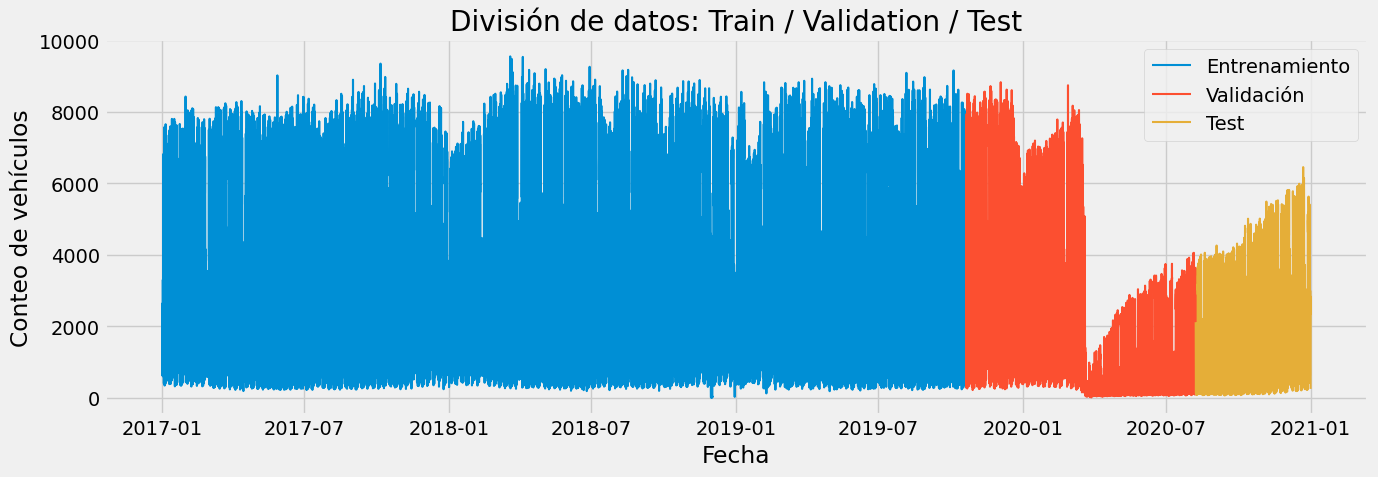

In [49]:
plt.figure(figsize=(14,5))
plt.plot(datos_train.index, datos_train['traffic_count'], label='Entrenamiento')
plt.plot(datos_val.index, datos_val['traffic_count'], label='Validación')
plt.plot(datos_test.index, datos_test['traffic_count'], label='Test')
plt.legend()
plt.title('División de datos: Train / Validation / Test')
plt.xlabel('Fecha')
plt.ylabel('Conteo de vehículos')
plt.tight_layout()
plt.show()


# 7. Modelado y entrenamiento

### 7.1. Creación y ajuste de modelos

In [50]:
from skforecast.recursive import ForecasterRecursive
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Definir los modelos a utilizar
metrics_modelos = {
    'XGB': XGBRegressor(random_state=123, verbosity=0),
    'LGBM': LGBMRegressor(random_state=123, n_jobs=1, verbose=0),
    'CatBoost': CatBoostRegressor(random_state=123, verbose=0)
}

# Creamos un diccionario para guardar los forecasters
forecasters = {}
for nombre, reg in metrics_modelos.items():
    print(f"Creando y ajustando modelo {nombre}")
    forecaster = ForecasterRecursive(
        regressor=reg,
        lags=24
    )
    if nombre == "LGBM":
        with suppress_stdout_stderr():
            forecaster.fit(
                y=datos_train['traffic_count'],
                exog=datos_train[variables_exogenas]
            )
    else:
        forecaster.fit(
            y=datos_train['traffic_count'],
            exog=datos_train[variables_exogenas]
        )
    forecasters[nombre] = forecaster
print("Todos los modelos han sido ajustados con los datos de entrenamiento.")

Creando y ajustando modelo XGB
Creando y ajustando modelo LGBM
Creando y ajustando modelo CatBoost
Todos los modelos han sido ajustados con los datos de entrenamiento.


### 7.2. Grid search de hiperparámetros y lags

In [51]:
from skforecast.model_selection import grid_search_forecaster, TimeSeriesFold

param_grids = {
    'XGB': {
        'n_estimators': [100, 300],
        'max_depth': [3, 7],
        'learning_rate': [0.05, 0.1]
    },
    'LGBM': {
        'n_estimators': [100, 300],
        'max_depth': [3, 7],
        'learning_rate': [0.05, 0.1]
    },
    'CatBoost': {
        'iterations': [100, 300],
        'depth': [3, 7],
        'learning_rate': [0.05, 0.1]
    }
}
lags_grid = [12, 24, 48]
resultados_grids = {}

cv = TimeSeriesFold(
    initial_train_size=len(datos_train),
    steps=36,
    refit=False
)

for nombre, forecaster in forecasters.items():
    print(f"Grid search para modelo {nombre}...")
    param_grid = param_grids[nombre]
    if nombre == "LGBM":
        with suppress_stdout_stderr():
            resultados_grid = grid_search_forecaster(
                forecaster=forecaster,
                y=datos.loc[:fin_validacion, 'traffic_count'],
                exog=datos.loc[:fin_validacion, variables_exogenas],
                cv=cv,
                param_grid=param_grid,
                lags_grid=lags_grid,
                metric='mean_squared_error',
                return_best=True,
                verbose=False,
                show_progress=True,
                n_jobs=-1
            )
    else:
        resultados_grid = grid_search_forecaster(
            forecaster=forecaster,
            y=datos.loc[:fin_validacion, 'traffic_count'],
            exog=datos.loc[:fin_validacion, variables_exogenas],
            cv=cv,
            param_grid=param_grid,
            lags_grid=lags_grid,
            metric='mean_squared_error',
            return_best=True,
            verbose=False,
            show_progress=True,
            n_jobs=-1
        )
    resultados_grids[nombre] = resultados_grid
    mejor = resultados_grid.loc[resultados_grid['mean_squared_error'].idxmin()]
    print(f"Mejores hiperparámetros {nombre}:\n{mejor}\n")

Grid search para modelo XGB...


lags grid: 100%|██████████| 3/3 [06:26<00:00, 128.69s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
  Backtesting metric: 2041116.9123318782
Mejores hiperparámetros XGB:
lags                  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
lags_label            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
params                {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...
mean_squared_error                                       2041116.912332
learning_rate                                                       0.1
max_depth                                                           3.0
n_estimators                                                      300.0
Name: 0, dtype: object

Grid search para modelo LGBM...
Mejores hiperparámetros LGBM:
lags                  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
lags_label            

lags grid: 100%|██████████| 3/3 [03:12<00:00, 64.03s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'depth': 7, 'iterations': 100, 'learning_rate': 0.05}
  Backtesting metric: 1886933.386081539
Mejores hiperparámetros CatBoost:
lags                  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
lags_label            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
params                {'depth': 7, 'iterations': 100, 'learning_rate...
mean_squared_error                                       1886933.386082
depth                                                               7.0
iterations                                                        100.0
learning_rate                                                      0.05
Name: 0, dtype: object



### 7.3. Backtesting y métricas


Backtesting para modelo XGB...


100%|██████████| 5/5 [00:00<00:00, 1667.72it/s]


MSE: 811548.347 | RMSE: 900.860
MSE % media: 14.87% | RMSE % media: 38.56%
Graficando predicción vs realidad en test...


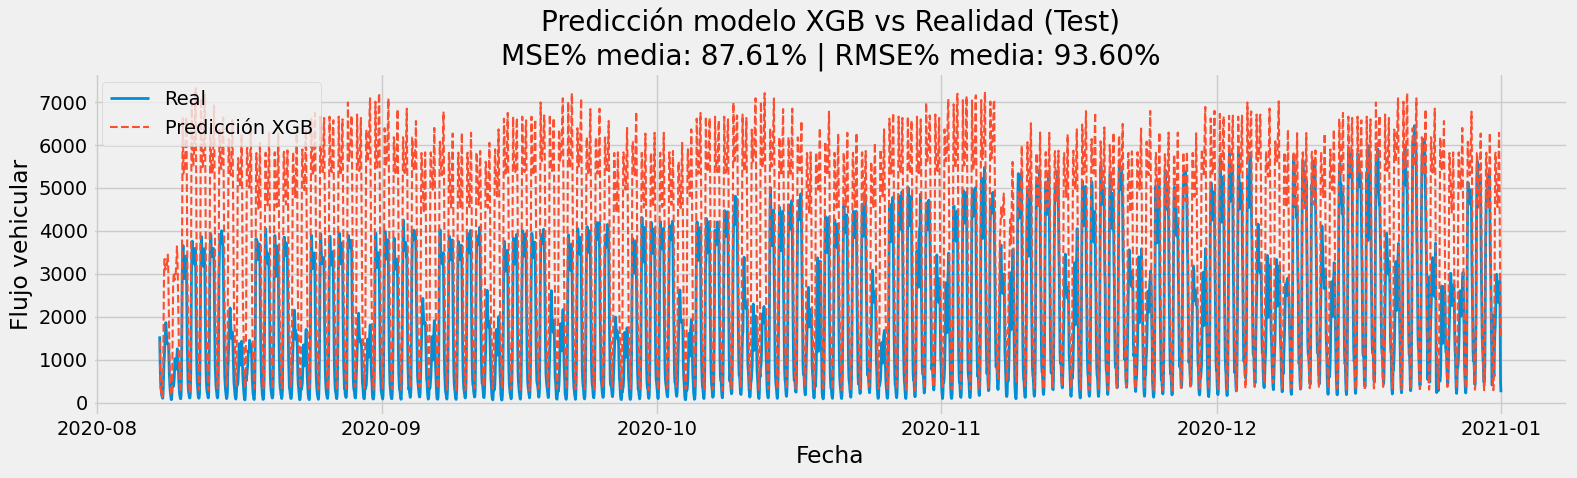


Backtesting para modelo LGBM...
MSE: 898938.593 | RMSE: 948.124
MSE % media: 16.47% | RMSE % media: 40.59%
Graficando predicción vs realidad en test...


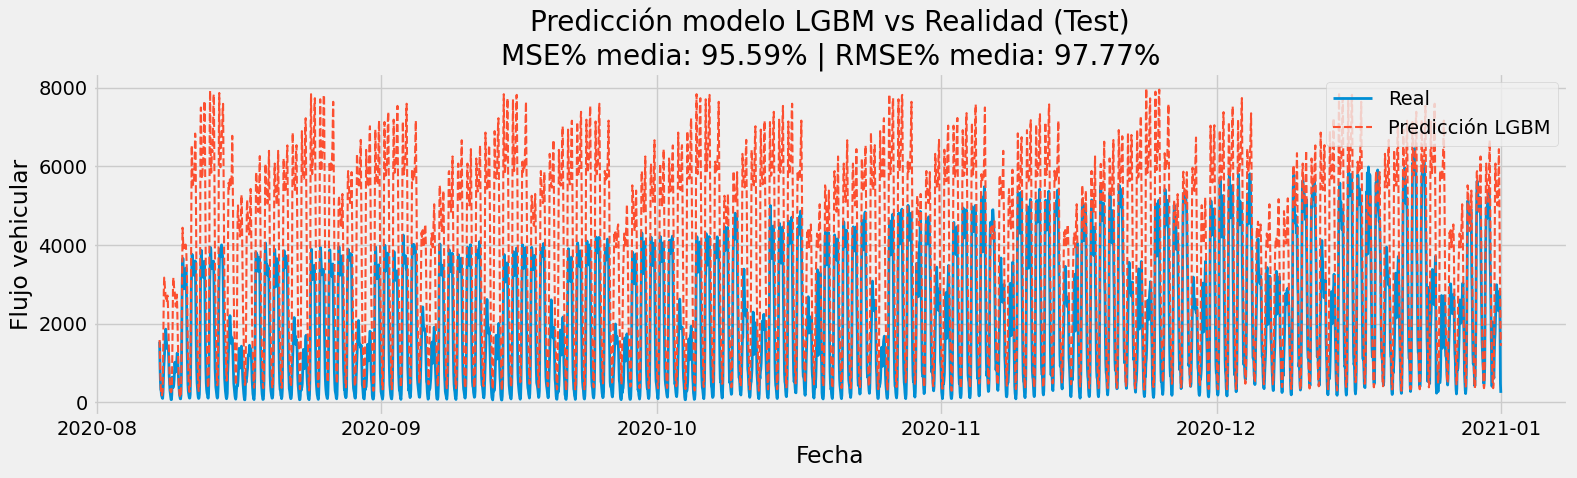


Backtesting para modelo CatBoost...


100%|██████████| 5/5 [00:00<?, ?it/s]


MSE: 1396246.505 | RMSE: 1181.629
MSE % media: 25.58% | RMSE % media: 50.58%
Graficando predicción vs realidad en test...


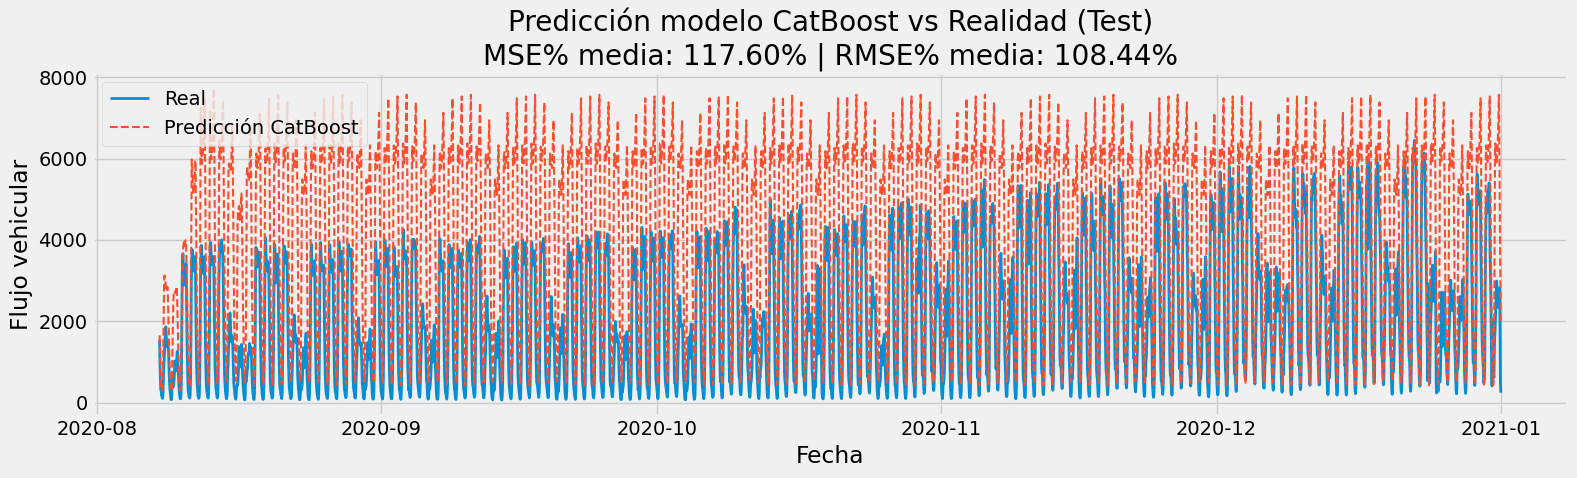

In [52]:
from skforecast.model_selection import backtesting_forecaster
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

n_folds = 5
steps = 36
n_total = len(datos['traffic_count'])
initial_train_size = n_total - steps * n_folds

cv_backtest = TimeSeriesFold(
    initial_train_size=initial_train_size,
    steps=steps,
    allow_incomplete_fold=False
)

# 1. Diccionario para guardar predicciones de test
predicciones_test_dict = {}

for nombre, forecaster in forecasters.items():
    print(f"\nBacktesting para modelo {nombre}...")
    if nombre == "LGBM":
        with suppress_stdout_stderr():
            metricas_cv, predicciones_cv = backtesting_forecaster(
                forecaster=forecaster,
                y=datos['traffic_count'],
                exog=datos[variables_exogenas],
                cv=cv_backtest,
                metric='mean_squared_error',
                verbose=False
            )
    else:
        metricas_cv, predicciones_cv = backtesting_forecaster(
            forecaster=forecaster,
            y=datos['traffic_count'],
            exog=datos[variables_exogenas],
            cv=cv_backtest,
            metric='mean_squared_error',
            verbose=False
        )
    y_val = datos['traffic_count'].iloc[-steps * n_folds:]
    mean_y_val = y_val.mean()
    mse = metricas_cv['mean_squared_error'].mean()
    mse_pct_media = mse / (mean_y_val ** 2) * 100
    rmse = np.sqrt(mse)
    rmse_pct_media = rmse / mean_y_val * 100
    print(f"MSE: {mse:.3f} | RMSE: {rmse:.3f}")
    print(f"MSE % media: {mse_pct_media:.2f}% | RMSE % media: {rmse_pct_media:.2f}%")

    # Gráfico en set de test y guardado de predicciones
    print("Graficando predicción vs realidad en test...")
    ultimo_val = datos_val.index.max()
    freq = datos.index.freq or pd.infer_freq(datos.index)
    if freq is None:
        freq = 'H'
    idx_test_start = pd.date_range(start=ultimo_val, periods=2, freq=freq)[-1]
    datos_test = datos.loc[idx_test_start:].copy()
    # Reentrenar el forecaster hasta el fin de validación
    if nombre == "LGBM":
        with suppress_stdout_stderr():
            forecaster.fit(
                y=datos.loc[:ultimo_val, 'traffic_count'],
                exog=datos.loc[:ultimo_val, variables_exogenas]
            )
    else:
        forecaster.fit(
            y=datos.loc[:ultimo_val, 'traffic_count'],
            exog=datos.loc[:ultimo_val, variables_exogenas]
        )
    predicciones = forecaster.predict(
        steps=len(datos_test),
        exog=datos_test[variables_exogenas]
    )
    predicciones_test_dict[nombre] = predicciones

    # (El gráfico individual lo puedes dejar si quieres)
    mse_test = ((datos_test['traffic_count'] - predicciones) ** 2).mean()
    mean_y_test = datos_test['traffic_count'].mean()
    mse_pct_media_test = mse_test / (mean_y_test ** 2) * 100
    rmse_test = mse_test ** 0.5
    rmse_pct_media_test = rmse_test / mean_y_test * 100
    plt.figure(figsize=(16, 5))
    plt.plot(datos_test.index, datos_test['traffic_count'], label='Real', linewidth=2)
    plt.plot(datos_test.index, predicciones, label=f'Predicción {nombre}', linestyle='dashed')
    plt.title(
        f'Predicción modelo {nombre} vs Realidad (Test)\n'
        f'MSE% media: {mse_pct_media_test:.2f}% | RMSE% media: {rmse_pct_media_test:.2f}%'
    )
    plt.xlabel('Fecha')
    plt.ylabel('Flujo vehicular')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [53]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Crear listas para armar el DataFrame
metrics_modelos = []
metrics_maes = []
metrics_rmses = []
metrics_r2s = []
metrics_mapes = []

y_true = datos_test['traffic_count'].values

for nombre, y_pred in predicciones_test_dict.items():
    # Asegura que sean arrays numpy y tengan la misma longitud
    y_pred = pd.Series(y_pred).values[:len(y_true)]
    metrics_modelos.append(nombre)
    metrics_maes.append(mean_absolute_error(y_true, y_pred))
    metrics_rmses.append(mean_squared_error(y_true, y_pred))
    metrics_r2s.append(r2_score(y_true, y_pred))
    mape = (abs((y_true - y_pred) / y_true).mean()) * 100
    metrics_mapes.append(mape)

# Construir DataFrame
df_metricas_test = pd.DataFrame({
    'MAE': metrics_maes,
    'RMSE': metrics_rmses,
    'R2': metrics_r2s,
    'MAPE (%)': metrics_mapes
}, index=metrics_modelos)


In [54]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Subplots: gráfico a la izquierda, tabla a la derecha
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.75, 0.25],
    specs=[[{"type": "xy"}, {"type": "table"}]]
)

# Línea real
fig.add_trace(go.Scatter(
    x=datos_test.index,
    y=datos_test['traffic_count'],
    mode='lines',
    name='Real',
    line=dict(width=2)
), row=1, col=1)

# Predicciones de los modelos
for nombre, pred in predicciones_test_dict.items():
    fig.add_trace(go.Scatter(
        x=datos_test.index,
        y=pred,
        mode='lines',
        name=f'Predicción {nombre}',
        line=dict(dash='dash')
    ), row=1, col=1)

# Tabla de métricas
fig.add_trace(go.Table(
    header=dict(
        values=['Modelo'] + list(df_metricas_test.columns),
        fill_color='paleturquoise',
        align='left'
    ),
    cells=dict(
        values=[df_metricas_test.index] + [df_metricas_test[col].round(2) for col in df_metricas_test.columns],
        fill_color='lavender',
        align='left'
    )
), row=1, col=2)

fig.update_layout(
    title='Comparación interactiva de predicciones y métricas',
    xaxis_title='Fecha',
    yaxis_title='Flujo vehicular',
    legend_title='Serie',
    template='plotly_white',
    autosize=True,
    width=1200,
    height=600,  # Dale un poco más de alto para la leyenda
    legend=dict(
        orientation="h",   # horizontal
        x=0,
        y=-0.55,            # Ajusta este valor según el resultado visual
        xanchor='left'
    )
)
fig.update_xaxes(rangeslider_visible=True, row=1, col=1)
fig.show()


In [55]:
mejores_params = {}
for nombre, resultados_grid in resultados_grids.items():
    mejores_params[nombre] = resultados_grid.loc[resultados_grid['mean_squared_error'].idxmin()].to_dict()

import joblib

for nombre, forecaster in forecasters.items():
    export_dict = {
        'model': forecaster,
        'variables_exogenas': variables_exogenas,
        'best_params': mejores_params[nombre]
    }
    path = f'models/v2/modelo_forecaster_{nombre}.pkl'
    joblib.dump(export_dict, path)
    print(f"Modelo {nombre} (con features y params) exportado como {path}")

Modelo XGB (con features y params) exportado como models/v2/modelo_forecaster_XGB.pkl
Modelo LGBM (con features y params) exportado como models/v2/modelo_forecaster_LGBM.pkl
Modelo CatBoost (con features y params) exportado como models/v2/modelo_forecaster_CatBoost.pkl
